# LSTM for new type of datasets

In [412]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn

import pandas as pd
import numpy as np

import plotly.express as px
from torch.optim import Adam

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

## Classes

In [413]:
# class SequentDataset(Dataset):
#     def __init__(self, dataframe: pd.DataFrame, n_dots=1, n_dot_parameters=4):
#         self.n_dot_parameters = n_dot_parameters
#         self.n_dots = n_dots
#         self.X_, self.y_ = self.__make_stack(dataframe)
#         # print(self.X_.shape)
#         # print(self.y_.shape)

#     def __len__(self):
#         return len(self.X_)

#     def __getitem__(self, idx):
#         return self.X_[idx], self.y_[idx]

#     def __make_stack(self, df: pd.DataFrame):
#         seq_amount = df.shape[0] - 2 * self.n_dots - 1
#         X = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
#         y = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
#         for i in range(seq_amount):
#             X[i, :, :] = torch.reshape(torch.tensor(df.values[i:i+self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))
#             y[i, :, :] = torch.reshape(torch.tensor(df.values[i+1:i+1+self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))

#         # stacks = [[df.iloc[:-self.n_dots]]] + [df.iloc[i:].values if (self.n_dots == i) else df.iloc[i:-(self.n_dots - i)].values for i in range(1, self.n_dots + 1)]
#         return (X, y)

In [414]:
class SequentDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, n_dots=1, n_dot_parameters=4):
        self.n_dot_parameters = n_dot_parameters
        self.n_dots = n_dots
        self.X_, self.y_ = self.__make_stack(dataframe)
        # print(self.X_.shape)
        # print(self.y_.shape)

    def __len__(self):
        return len(self.X_)

    def __getitem__(self, idx):
        return self.X_[idx], self.y_[idx]

    def __make_stack(self, df: pd.DataFrame):
        seq_amount = df.shape[0] - 2 * self.n_dots - 1
        X = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
        y = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
        for i in range(seq_amount):  
            X[i, :, :] = torch.reshape(torch.tensor(df.values[i:i+self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))
            y[i, :, :] = torch.reshape(torch.tensor(df.values[i+self.n_dots : i+2*self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))
            

        # stacks = [[df.iloc[:-self.n_dots]]] + [df.iloc[i:].values if (self.n_dots == i) else df.iloc[i:-(self.n_dots - i)].values for i in range(1, self.n_dots + 1)]
        return (X, y)

In [415]:
class DatasetForTrain(Dataset):
    def __init__(self, x, y):
        self.X_ = x
        self.y_ = y

    def __len__(self):
        return len(self.X_)

    def __getitem__(self, idx):
        return self.X_[idx], self.y_[idx]

In [416]:
class RNNModel(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=100, output_size=4, num_layers=10):
        super(RNNModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.rnn = nn.RNN(input_size, hidden_layer_size, num_layers, batch_first=True)

        # Define the output layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        # x = x.to(device)
        batch_size = x.size(0)
        self.h = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).requires_grad_()
        self.h = self.h
        out, _ = self.rnn(x, self.h)

        # print(out.size())

        # Pass through fully connected layer
        out = self.linear(out)  # We want the output corresponding to the last time step
        return out

In [417]:
N_DOTS = 25
BATCH_SIZE = 1
N_DOT_PARAMETERS = 4
N_LSTM_LAYERS = 1

In [418]:
trajectory_train = pd.read_csv("../../sets_for_article/dash_slope_train.csv")
trajectory_test = pd.read_csv("../../sets_for_article/dash_slope_test.csv")

trajectory_train['t'] = 1
trajectory_test['t'] = 1

In [419]:
fig = px.line_3d(trajectory_train, x="X", y="Y", z="Z", color='I')
fig.show()

In [420]:
num_train = trajectory_train['I'].max()
dashes_train = []
# num_train=0
for i in range(num_train+1):
    temp = trajectory_train[trajectory_train['I'] == i]
    temp_dataset = SequentDataset(temp[['t','X','Y','Z']], N_DOTS, N_DOT_PARAMETERS)
    dashes_train.append(temp_dataset)


num_test = trajectory_test['I'].max()
dashes_test = []
# num_test=0
for i in range(num_test+1):
    temp = trajectory_test[trajectory_test['I'] == i]
    temp_dataset = SequentDataset(temp[['t','X','Y','Z']], N_DOTS, N_DOT_PARAMETERS)
    dashes_test.append(temp_dataset)

In [421]:
len(dashes_test[0])

949

In [422]:
for_train_x = torch.zeros(1,dashes_train[0][0][0].size()[0],N_DOT_PARAMETERS)
for_train_y = torch.zeros(1,dashes_train[0][0][1].size()[0],N_DOT_PARAMETERS)
for dash in dashes_train:
    temp_x, temp_y = dash[:]
    # print(temp_x)
    # break
    for_train_x = torch.cat([for_train_x,temp_x],dim=0)
    for_train_y = torch.cat([for_train_y,temp_y],dim=0)

# Указание индекса строки, которую нужно удалить
row_index_to_delete = 0

# Генерация индексов строк, которые нужно сохранить
indices_to_keep = torch.tensor([i for i in range(for_train_x.size(0)) if i != row_index_to_delete])

for_train_x = torch.index_select(for_train_x, dim=0, index=indices_to_keep)
for_train_y = torch.index_select(for_train_y, dim=0, index=indices_to_keep)

train = DatasetForTrain(for_train_x, for_train_y)

In [423]:
model = RNNModel(input_size=N_DOT_PARAMETERS, num_layers=N_LSTM_LAYERS)
# loss_model = nn.L1Loss()
loss_model = nn.HuberLoss()
# loss_model = nn.MSELoss()
# opt = Adam(model.parameters(), lr=0.005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)

In [424]:
opt = Adam(model.parameters(), lr=0.005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=0.5, patience=3, threshold=1e-3, cooldown=0, min_lr=1e-6)

In [425]:
# model.load_state_dict(torch.load("rnn_dach_30_10.pt"))

In [426]:
def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    train_loss = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
    
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    
    return sum(train_loss)/len(train_loss)

In [427]:
def evaluate_model(model, criterion, test_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss.append(loss.item())
    return sum(val_loss)/len(val_loss)

In [428]:
EPOCH = 30
N_DASH = len(dashes_train)
train_losses = []
val_losses = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)

train_data, val_data = random_split(train,[0.8,0.2])

# for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
#     print(f'Fold {fold + 1}/{10}')

#     X_train, X_test = train[train_idx][0], train[test_idx][0]
#     y_train, y_test = train[train_idx][1], train[test_idx][1]

train_loader = DataLoader(train_data, batch_size=8, shuffle=False)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

for epoch in range(EPOCH):

    mean_train_loss = train_model(model, loss_model, opt, train_loader, "cpu")

    train_losses.append(mean_train_loss)

    mean_val_loss = evaluate_model(model, loss_model, val_loader, "cpu")

    val_losses.append(mean_val_loss)

    lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()

    print(f"Epoch [{epoch+1}/{EPOCH}], train_loss = {mean_train_loss:.4f}, val_loss = {mean_val_loss:.4f}, lr = {lr}")

Epoch [1/30], train_loss = 4.2499, val_loss = 1.0400, lr = [0.005]
Epoch [2/30], train_loss = 0.8871, val_loss = 0.7507, lr = [0.005]
Epoch [3/30], train_loss = 0.7546, val_loss = 0.6536, lr = [0.0025]
Epoch [4/30], train_loss = 0.3663, val_loss = 0.3316, lr = [0.0025]
Epoch [5/30], train_loss = 0.3211, val_loss = 0.3104, lr = [0.0025]
Epoch [6/30], train_loss = 0.2975, val_loss = 0.2583, lr = [0.00125]
Epoch [7/30], train_loss = 0.1861, val_loss = 0.1799, lr = [0.00125]
Epoch [8/30], train_loss = 0.1793, val_loss = 0.1652, lr = [0.00125]
Epoch [9/30], train_loss = 0.1686, val_loss = 0.1676, lr = [0.000625]
Epoch [10/30], train_loss = 0.1345, val_loss = 0.1286, lr = [0.000625]
Epoch [11/30], train_loss = 0.1308, val_loss = 0.1233, lr = [0.000625]
Epoch [12/30], train_loss = 0.1261, val_loss = 0.1189, lr = [0.0003125]
Epoch [13/30], train_loss = 0.1127, val_loss = 0.1092, lr = [0.0003125]
Epoch [14/30], train_loss = 0.1107, val_loss = 0.1069, lr = [0.0003125]
Epoch [15/30], train_loss =

In [429]:
torch.save(model.state_dict(),"rnn_dach_31_10.pt")

<function matplotlib.pyplot.show(close=None, block=None)>

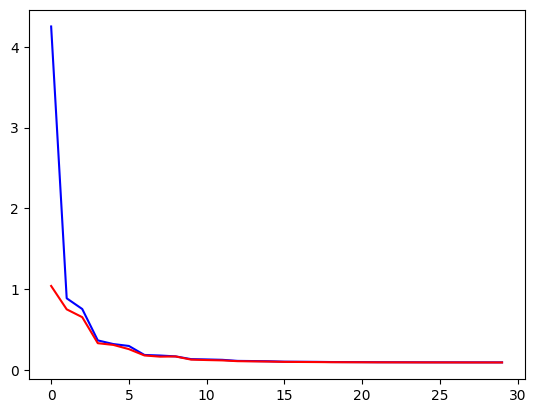

In [430]:
plt.plot(train_losses, '-b')
plt.plot(val_losses, '-r')
plt.show

In [431]:
# all_predictions = []
# model.eval()
# with torch.no_grad():
#     for dash in dashes_train:
#         sequence, _ = dash[0]
#         predictions = []
#         test_loader = DataLoader(dash, batch_size=8, shuffle=False)
#         for X,y in test_loader:
#             for i in range(N_DOTS, len(dash)):
#                 y_pred = model(X)
#                 predictions.append(y_pred[0, -1, :])
#                 X[0, :-1, :] = X.clone()[0, 1:, :]
#                 X[0, -1, :] = y_pred[0, -1, :]
#             all_predictions.append(predictions)
#             break

In [432]:
all_predictions = []
model.eval()
with torch.no_grad():
    for dash in dashes_train:
        sequence, _ = dash[0]
        predictions = []
        test_loader = DataLoader(dash, batch_size=8, shuffle=False)
        for X,y in test_loader:
            for i in range(N_DOTS, len(dash)):
                y_pred = model(X)
                predictions.append(y_pred[0, -1, :])
                X = y_pred
            all_predictions.append(predictions)
            break

In [433]:
pred_data = pd.DataFrame([[0,0,0,0,0]], columns=["Time", "X", "Y", "Z", "I"])

for i in range(len(all_predictions)):
    p_x = pd.DataFrame(np.vstack(list(map(lambda x: x.detach().numpy(), all_predictions[i]))), columns=["Time", "X", "Y", "Z"])
    p_x['I'] = "Predict_" + str(i)
    _, y  = dashes_train[i][:]
    p_y = pd.DataFrame(y.detach().numpy()[:, 0, :], columns=["Time", "X", "Y", "Z"])
    p_y['I'] = "True_" + str(i)
    pred_data = pd.concat([pred_data,p_x,p_y],axis=0)

aaaab = pred_data.drop(pred_data.index[0], inplace=False)


In [434]:
fig = px.line_3d(aaaab, x="X", y="Y", z="Z", color='I')
fig.show()